In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr, linregress, ttest_ind
import lmfit
from scipy.stats import norm

from General.import_funcs import drive_letter
from General.experiments import SpectroData, WavelengthCalibration
from General.plotting import plot, cbar, linestyles

loc = r'E:\OneDrive - TU Eindhoven\Master thesis\Measurements\24_02_23'
spectrum = r'Hg-Ar lamp.txt'
dark = r'Dark.txt'
save_loc = r'E:\OneDrive - TU Eindhoven\Master thesis\Tex\Images\Setup\peak_fit'
spectrum = SpectroData.read_data(f'{loc}\\{spectrum}')
dark = SpectroData.read_data(f'{loc}\\{dark}')

wavelengths = spectrum.spectrum.wavelengths
intensity = spectrum.spectrum.intensities - dark.spectrum.intensities

C:\Users\20222772\PycharmProjects\MasterDataAnalysis\General\plotting\plot.py:350: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


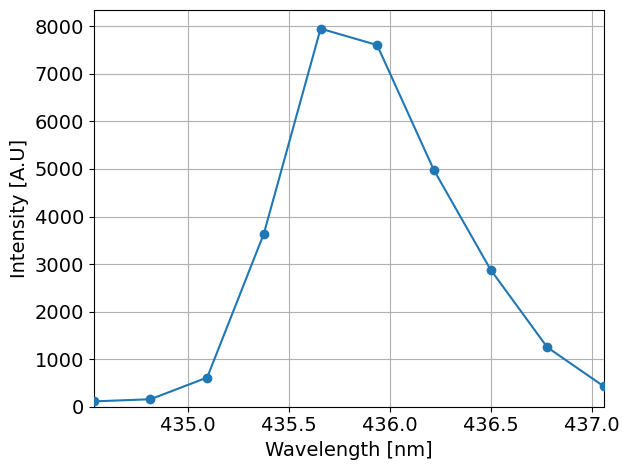

In [2]:
wavelength = 435.8335
mask = (wavelengths > wavelength - 1.5) & (wavelengths < wavelength + 1.5)
line_kwargs = {'linestyle': '-', 'marker': 'o'}
plot_kwargs = {'xlabel': 'Wavelength [nm]', 'ylabel': 'Intensity [A.U]', 'ylim': 0}
plot.lines(wavelengths[mask], intensity[mask], line_kwargs=line_kwargs, plot_kwargs=plot_kwargs, save_loc=f'{save_loc}_1.pdf')

C:\Users\20222772\PycharmProjects\MasterDataAnalysis\General\plotting\plot.py:350: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


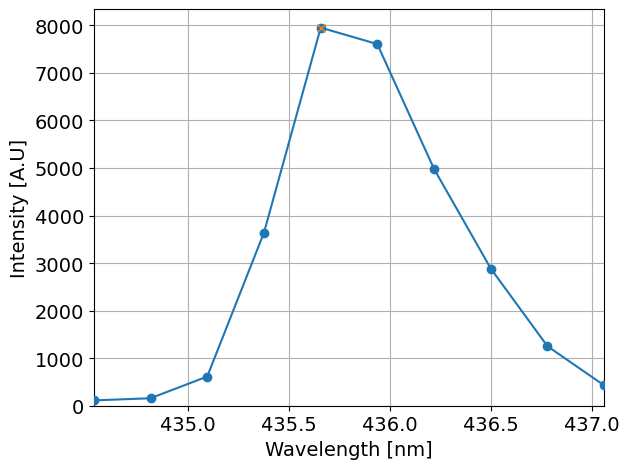

In [3]:
top_index = np.argmax(intensity[mask])
fig_ax = plot.lines(wavelengths[mask], intensity[mask], line_kwargs=line_kwargs, plot_kwargs=plot_kwargs, show=False)
plot.lines([wavelengths[mask][top_index]], [intensity[mask][top_index]], fig_ax=fig_ax, line_kwargs={'marker': 'x', 'color': 'red'}, plot_kwargs=plot_kwargs, save_loc=f'{save_loc}_2.pdf')

C:\Users\20222772\PycharmProjects\MasterDataAnalysis\General\plotting\plot.py:350: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


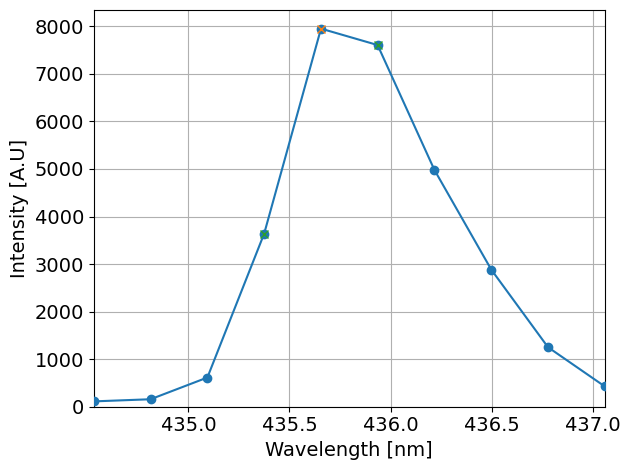

In [4]:
top_index = np.argmax(intensity[mask])
fig_ax = plot.lines(wavelengths[mask], intensity[mask], line_kwargs=line_kwargs, plot_kwargs=plot_kwargs, show=False)
plot.lines([wavelengths[mask][top_index]], [intensity[mask][top_index]], fig_ax=fig_ax, line_kwargs={'marker': 'x', 'color': 'red'}, show=False)
plot.lines([wavelengths[mask][top_index-1], wavelengths[mask][top_index+1]], [intensity[mask][top_index-1], intensity[mask][top_index+1]], fig_ax=fig_ax, line_kwargs={'marker': 'x', 'color': 'green', 'linestyle': 'none'}, plot_kwargs=plot_kwargs, save_loc=f'{save_loc}_3.pdf')

C:\Users\20222772\PycharmProjects\MasterDataAnalysis\General\plotting\plot.py:350: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


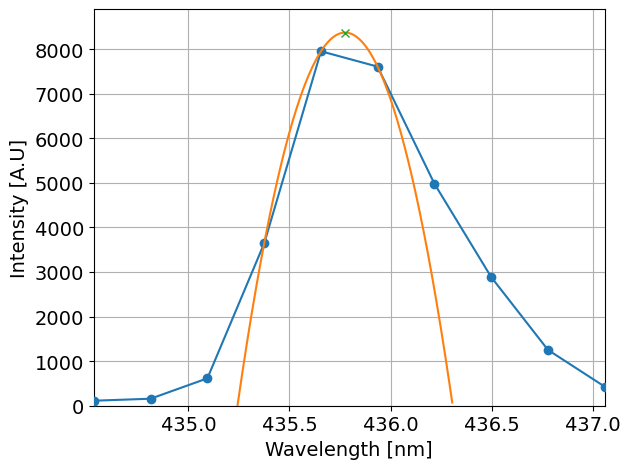

In [5]:
top_index = np.argmax(intensity[mask])
plot_kwargs['ylim'] = (0, 8900)
fig_ax = plot.lines(wavelengths[mask], intensity[mask], line_kwargs=line_kwargs, plot_kwargs=plot_kwargs, show=False)
quadratic = WavelengthCalibration.quadratic(wavelengths[mask][top_index-1:top_index+2], intensity[mask][top_index-1:top_index+2])
wavs = np.linspace(wavelengths[mask][0], wavelengths[mask][-1], 1000)
line = quadratic[0]*(wavs**2) + quadratic[1]*wavs + quadratic[2]
maskerino = (line > 0) & (line < 1.1*intensity[mask][top_index])
plot.lines(wavs[maskerino], line[maskerino], fig_ax=fig_ax, line_kwargs={'color': 'orange'}, show=False)
peak = WavelengthCalibration.quadratic_peak(wavelengths[mask][top_index-1:top_index+2], intensity[mask][top_index-1:top_index+2])
plot.lines([peak], [quadratic[0]*(peak**2) + quadratic[1]*peak + quadratic[2]], fig_ax=fig_ax, line_kwargs={'marker': 'x', 'color': 'red'}, plot_kwargs=plot_kwargs, save_loc=f'{save_loc}_4.pdf')

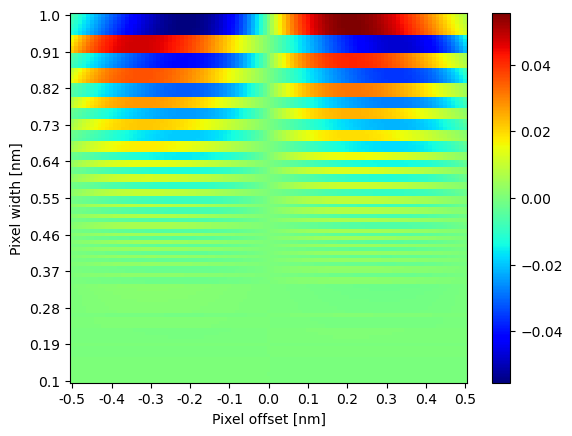

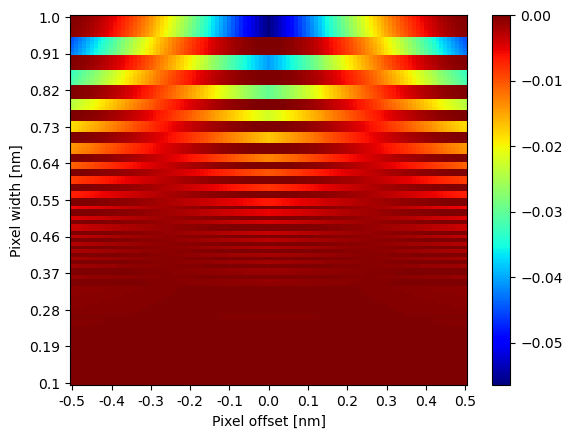

In [10]:
def gauss(x, a, b, c):
    return a * np.exp(-(x - b)**2 / (2 * c**2))

pixel_widths = np.linspace(0.1, 1, 101)
pixel_offsets = np.linspace(-0.5, 0.5, 101)
locs = np.zeros((len(pixel_widths), len(pixel_offsets)))
heights = np.zeros_like(locs)

for i, pixel_width in enumerate(pixel_widths):
    x_vals = np.linspace(-10, 10, int(20//pixel_width))
    for j, pixel_offset in enumerate(pixel_offsets):
        y_vals = gauss(x_vals, 1, pixel_width*pixel_offset, 1)
        index = np.argmax(y_vals)
        loc, height = WavelengthCalibration.quadratic_peak_xy(x_vals[index-1:index+2], y_vals[index-1:index+2])
        locs[i, j] = loc - pixel_width*pixel_offset
        heights[i, j] = height - 1


every = 10
plt.figure()
plt.imshow(locs, aspect='auto', cmap='jet', origin='lower')
plt.xticks(np.arange(0, len(pixel_offsets))[::every], np.round(pixel_offsets[::every], 2))
plt.yticks(np.arange(0, len(pixel_widths))[::every], np.round(pixel_widths[::every], 2))
plt.colorbar()
plt.xlabel('Pixel offset [nm]')
plt.ylabel('Pixel width [nm]')
plt.show()

plt.figure()
plt.imshow(heights, aspect='auto', cmap='jet', origin='lower')
plt.xticks(np.arange(0, len(pixel_offsets))[::every], np.round(pixel_offsets[::every], 2))
plt.yticks(np.arange(0, len(pixel_widths))[::every], np.round(pixel_widths[::every], 2))
plt.xlabel('Pixel offset [nm]')
plt.ylabel('Pixel width [nm]')
plt.colorbar()
plt.show()


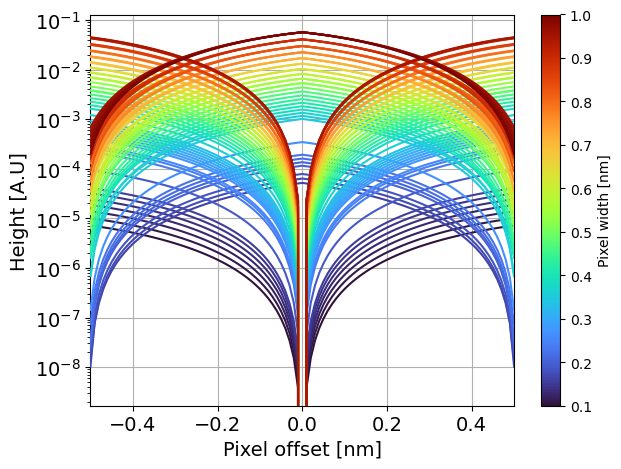

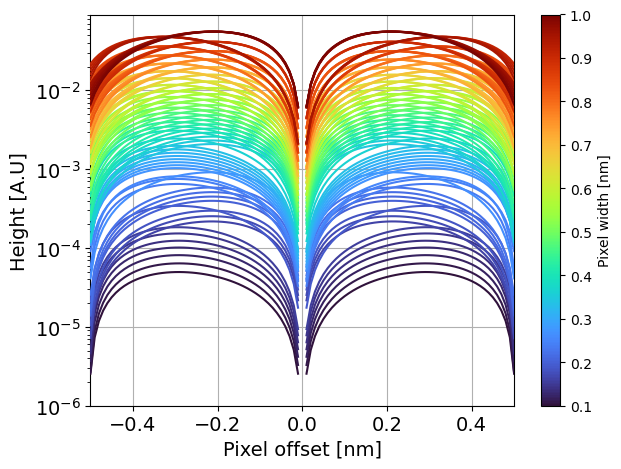

In [13]:
colors, sm = cbar.cbar_norm_colors(pixel_widths)
cbar_kwargs = {'label': 'Pixel width [nm]', 'mappable': sm}
plot_kwargs = {'xlabel': 'Pixel offset [nm]', 'ylabel': 'Height [A.U]'}
plot.semilogy(pixel_offsets, abs(heights), colors=colors, cbar_kwargs=cbar_kwargs, plot_kwargs=plot_kwargs)
plot_kwargs['ylim'] = (1e-6, None)
plot.semilogy(pixel_offsets, abs(locs), colors=colors, cbar_kwargs=cbar_kwargs, plot_kwargs=plot_kwargs)